Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model, lr=1e-2):

    # covariance matrix before training
    X = model.forward(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.R -= lr * model.R.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # covariance matrix after training
    X = model.forward(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return D, V, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	total loss: 0.162
iteration 1	total loss: 0.161
iteration 2	total loss: 0.160
iteration 3	total loss: 0.158
iteration 4	total loss: 0.157
iteration 5	total loss: 0.155
iteration 6	total loss: 0.154
iteration 7	total loss: 0.153
iteration 8	total loss: 0.151
iteration 9	total loss: 0.150
iteration 0	total loss: 0.146
iteration 1	total loss: 0.145
iteration 2	total loss: 0.144
iteration 3	total loss: 0.143
iteration 4	total loss: 0.142
iteration 5	total loss: 0.140
iteration 6	total loss: 0.139
iteration 7	total loss: 0.138
iteration 8	total loss: 0.137
iteration 9	total loss: 0.136
iteration 0	total loss: 0.018
iteration 1	total loss: 0.018
iteration 2	total loss: 0.018
iteration 3	total loss: 0.017
iteration 4	total loss: 0.017
iteration 5	total loss: 0.017
iteration 6	total loss: 0.017
iteration 7	total loss: 0.017
iteration 8	total loss: 0.017
iteration 9	total loss: 0.017


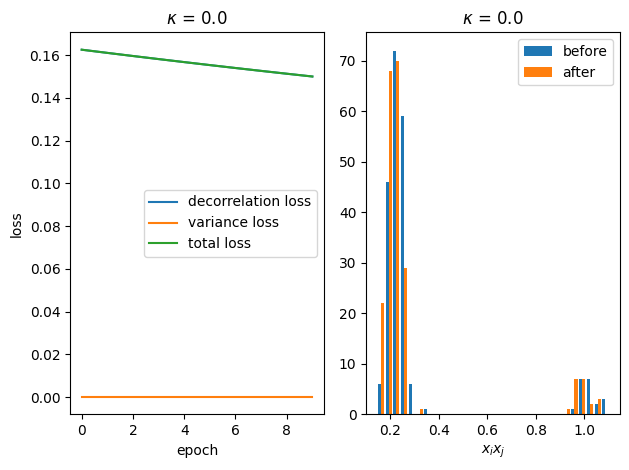

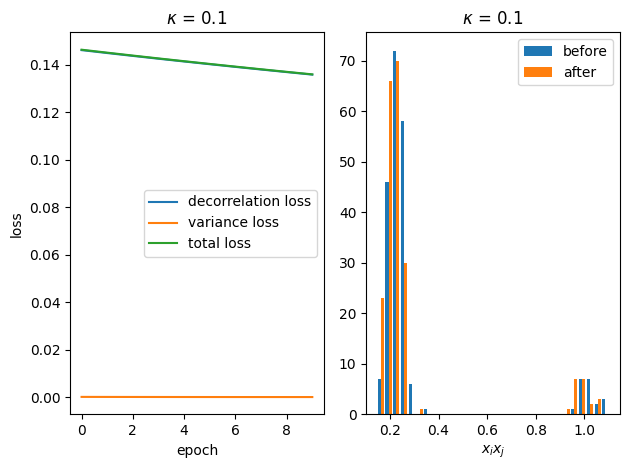

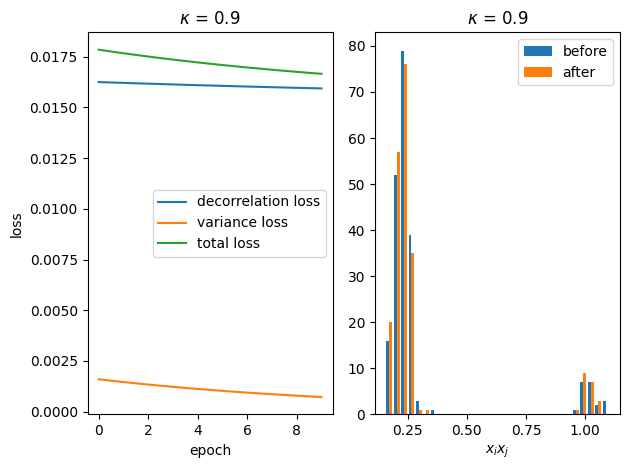

In [4]:
num_samples=1000
num_features=20
num_epochs=1000
kappas = [0.0, 0.1, 0.9]
lr=1e-1

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

for kappa in kappas:

    # create a decorrelator
    model = Decorrelation(size=num_features, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

Decorrelation of correlated input using DecorConv2d

In [3]:
def decorrelate(num_epochs, data, model, lr=1e-2):
    # specifically for current conv2d implementation

    # covariance matrix before training
    # NOT CORRECT. REQUIRES PATCHES!!!
    X = model.forward(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.weight -= lr * model.weight.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # covariance matrix after training
    X = model.forward(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return D, V, A1, A2

iteration 0	total loss: 1.339
iteration 1	total loss: 0.882
iteration 2	total loss: 1.006
iteration 3	total loss: 0.734
iteration 4	total loss: 0.653
iteration 5	total loss: 0.615
iteration 6	total loss: 0.719
iteration 7	total loss: 0.564
iteration 8	total loss: 0.740
iteration 9	total loss: 0.568


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

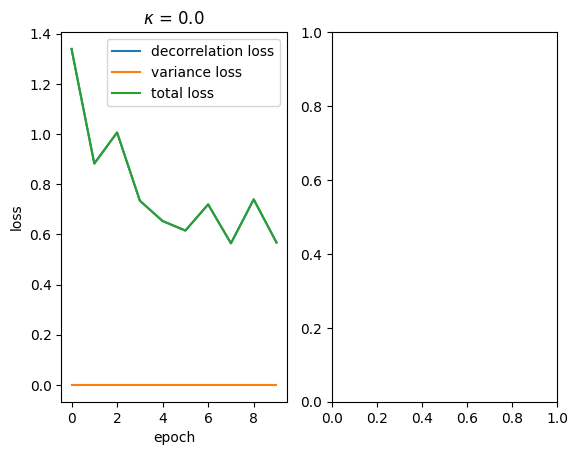

In [4]:
# generate [N, M] correlated input
num_examples=100
in_channels=2
out_channels=3
height=20
width=20
num_features=in_channels*height*width
kernel_size=(5,5)
num_samples=1000
num_epochs=10
kappas = [0.0, 0.1, 0.25, 0.5]
lr=1e-3

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

for kappa in kappas:

    # create a convolutional decorrelator
    model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

In [4]:
A1

tensor([[ 0.2036,  0.1734,  0.1688,  ..., -0.2367, -0.2384, -0.2192],
        [ 0.1734,  0.2282,  0.1996,  ..., -0.2477, -0.2559, -0.2320],
        [ 0.1688,  0.1996,  0.2278,  ..., -0.2437, -0.2491, -0.2259],
        ...,
        [-0.2367, -0.2477, -0.2437,  ...,  0.3640,  0.3366,  0.3042],
        [-0.2384, -0.2559, -0.2491,  ...,  0.3366,  0.3753,  0.3112],
        [-0.2192, -0.2320, -0.2259,  ...,  0.3042,  0.3112,  0.3209]],
       grad_fn=<DivBackward0>)

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison